In [5]:
# ---------- 0. Imports & Setup ----------
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib
import os

In [6]:
# Optional: show plots inline
%matplotlib inline
sns.set(style='whitegrid', context='notebook')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [7]:

# ---------- 1. Synthetic Data Generation ----------
districts = [
    "Taplejung","Sankhuwasabha","Solukhumbu","Okhaldhunga","Khotang","Bhojpur",
    "Dhankuta","Terhathum","Panchthar","Ilam","Jhapa","Morang","Sunsari",
    "Udayapur","Saptari","Siraha","Dhanusa","Mahottari","Sarlahi",
    "Sindhuli","Ramechhap","Dolakha",
    "Kavrepalanchok","Sindhupalchok","Rasuwa","Nuwakot","Dhading",
    "Kathmandu","Bhaktapur","Lalitpur","Makwanpur","Chitwan",
    "Gorkha","Manang","Mustang","Myagdi","Kaski","Lamjung","Tanahun",
    "Syangja","Parbat","Baglung","Gulmi","Palpa",
    "Nawalparasi East (Nawalpur)","Nawalparasi West (Parasi)",
    "Rupandehi","Kapilvastu","Arghakhanchi","Pyuthan","Rolpa",
    "Rukum East","Rukum West",
    "Salyan","Dang","Banke","Bardiya",
    "Surkhet","Dailekh","Jajarkot","Jumla","Kalikot","Mugu","Humla","Dolpa",
    "Kailali","Kanchanpur","Dadeldhura","Baitadi","Darchula",
    "Achham","Bajura","Bajhang","Doti"
]




In [8]:


# Optional: show plots inline
%matplotlib inline
sns.set(style='whitegrid', context='notebook')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# ---------- 1. Synthetic Data Generation ----------
districts = [
    "Taplejung","Sankhuwasabha","Solukhumbu","Okhaldhunga","Khotang","Bhojpur",
    "Dhankuta","Terhathum","Panchthar","Ilam","Jhapa","Morang","Sunsari",
    "Udayapur","Saptari","Siraha","Dhanusa","Mahottari","Sarlahi",
    "Sindhuli","Ramechhap","Dolakha",
    "Kavrepalanchok","Sindhupalchok","Rasuwa","Nuwakot","Dhading",
    "Kathmandu","Bhaktapur","Lalitpur","Makwanpur","Chitwan",
    "Gorkha","Manang","Mustang","Myagdi","Kaski","Lamjung","Tanahun",
    "Syangja","Parbat","Baglung","Gulmi","Palpa",
    "Nawalparasi East (Nawalpur)","Nawalparasi West (Parasi)",
    "Rupandehi","Kapilvastu","Arghakhanchi","Pyuthan","Rolpa",
    "Rukum East","Rukum West",
    "Salyan","Dang","Banke","Bardiya",
    "Surkhet","Dailekh","Jajarkot","Jumla","Kalikot","Mugu","Humla","Dolpa",
    "Kailali","Kanchanpur","Dadeldhura","Baitadi","Darchula",
    "Achham","Bajura","Bajhang","Doti"
]

n_samples = 4000  # adjust as needed (3000-5000 recommended)
np.random.seed(RANDOM_STATE)

data = {
    "district": np.random.choice(districts, n_samples),
    "household_size": np.random.randint(1, 12, n_samples),
    "monthly_income_npr": np.random.normal(35000, 16000, n_samples).clip(3000, 200000),
    "land_owned_hectares": np.random.exponential(0.6, n_samples).clip(0, 10),
    "crop_diversity_score": np.random.randint(1, 11, n_samples),
    "livestock_count": np.random.poisson(3, n_samples).clip(0, 50),
    "distance_to_market_km": np.random.randint(0, 50, n_samples),
    "remittance_income": np.random.exponential(15000, n_samples).clip(0, 200000),
    "education_years_head": np.random.randint(0, 17, n_samples),
    "meals_per_day": np.random.choice([1,2,3], n_samples, p=[0.08,0.35,0.57]),
    "diet_diversity_score": np.random.randint(1, 13, n_samples),
    "disaster_exposure_count": np.random.randint(0, 6, n_samples),
    "water_access": np.random.choice([0,1], n_samples, p=[0.32,0.68])
}

df = pd.DataFrame(data)

# Create a probabilistic target (0=Secure,1=Moderate,2=Severe)
def compute_food_security_score(row):
    score = 0.0
    # income effect (lower income increases insecurity)
    if row["monthly_income_npr"] < 10000:
        score += 3
    elif row["monthly_income_npr"] < 20000:
        score += 2
    elif row["monthly_income_npr"] < 30000:
        score += 1
    # household pressure
    if row["household_size"] > 6:
        score += 1.5
    if row["household_size"] > 8:
        score += 1
    # land and remittance act as cushions
    if row["land_owned_hectares"] < 0.2:
        score += 1
    elif row["land_owned_hectares"] > 1.0:
        score -= 1
    if row["remittance_income"] > 10000:
        score -= 1.2
    # meals and diet diversity
    if row["meals_per_day"] == 1:
        score += 2
    elif row["meals_per_day"] == 2:
        score += 0.7
    if row["diet_diversity_score"] < 4:
        score += 1.5
    if row["crop_diversity_score"] < 3:
        score += 0.5
    # disasters and water
    if row["disaster_exposure_count"] >= 3:
        score += 1
    if row["water_access"] == 0:
        score += 0.8
    # education decreases risk slightly
    if row["education_years_head"] >= 10:
        score -= 0.7
    # distance to market increases insecurity a bit
    if row["distance_to_market_km"] > 20:
        score += 0.6
    # random noise to ensure not 100% rules
    score += np.random.normal(0, 0.6)
    return score

df['risk_score'] = df.apply(compute_food_security_score, axis=1)

# Map risk_score into classes with thresholds tuned for balanced-ish classes
def risk_to_class(r):
    if r <= 1.5:
        return 0  # Food Secure
    elif r <= 4.0:
        return 1  # Moderately insecure
    else:
        return 2  # Severely insecure

df['food_security_status'] = df['risk_score'].apply(risk_to_class)

# Drop risk_score for modeling later (keep if you want)
df = df.drop(columns=['risk_score'])

# Quick class balance check
print("Class counts:\n", df['food_security_status'].value_counts(normalize=False))
print("\nClass proportions:\n", df['food_security_status'].value_counts(normalize=True))

# Save dataset to CSV (for submission)
os.makedirs('data', exist_ok=True)
df.to_csv('data/synthetic_food_security_nepal.csv', index=False)
print("\nSaved dataset to data/synthetic_food_security_nepal.csv")


Class counts:
 food_security_status
1    1691
0    1197
2    1112
Name: count, dtype: int64

Class proportions:
 food_security_status
1    0.42275
0    0.29925
2    0.27800
Name: proportion, dtype: float64

Saved dataset to data/synthetic_food_security_nepal.csv


,district,household_size,monthly_income_npr,land_owned_hectares,crop_diversity_score,livestock_count,distance_to_market_km,remittance_income,education_years_head,meals_per_day,diet_diversity_score,disaster_exposure_count,water_access,food_security_status
0,Rukum East,3,58449.222150,1.659615,3,2,12,336.208097,3,2,11,4,0,0
1,Saptari,9,27354.745962,0.054907,1,6,49,10101.633810,16,2,1,2,0,2
2,Bajura,4,39624.199289,0.489733,2,3,41,3802.711467,13,3,11,1,1,0
3,Jumla,3,46231.319866,0.175722,6,6,44,13085.095404,9,2,7,3,0,1
4,Ramechhap,11,39940.131269,0.089838,5,5,24,25482.901206,8,3,1,1,0,2


,district,household_size,monthly_income_npr,land_owned_hectares,crop_diversity_score,livestock_count,distance_to_market_km,remittance_income,education_years_head,meals_per_day,diet_diversity_score,disaster_exposure_count,water_access,food_security_status
count,4000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.00000,4000.00000,4000.000000
unique,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Ramechhap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.024250,35147.985960,0.602930,5.474250,3.021750,24.408500,15011.182336,7.91475,2.476250,6.452500,2.46225,0.68750,0.978750
std,NaN,3.150181,15657.612280,0.596547,2.886247,1.726274,14.295322,15015.737328,4.90362,0.636818,3.454233,1.70889,0.46357,0.759567
min,NaN,1.000000,3000.000000,0.000071,1.000000,0.000000,0.000000,3.047788,0.00000,1.000000,1.000000,0.00000,0.00000,0.000000
25%,NaN,3.000000,24068.963124,0.178070,3.000000,2.000000,12.000000,4374.316291,4.00000,2.000000,3.000000,1.00000,0.00000,0.000000
50%,NaN,6.000000,35332.792846,0.423579,6.000000,3.000000,25.000000,10154.551946,8.00000,3.000000,6.000000,2.00000,1.00000,1.000000
75%,NaN,9.000000,45929.086491,0.827179,8.000000,4.000000,37.000000,20858.775076,12.00000,3.000000,9.000000,4.00000,1.00000,2.000000


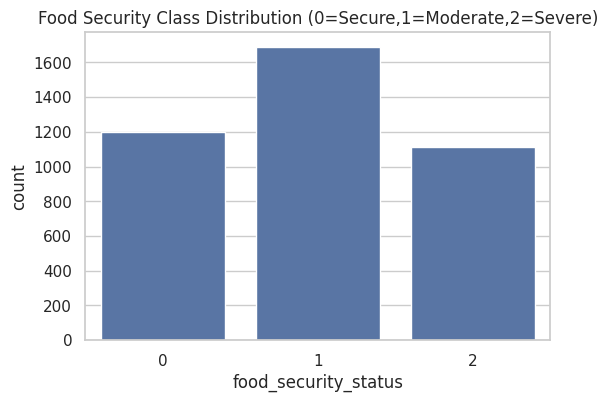

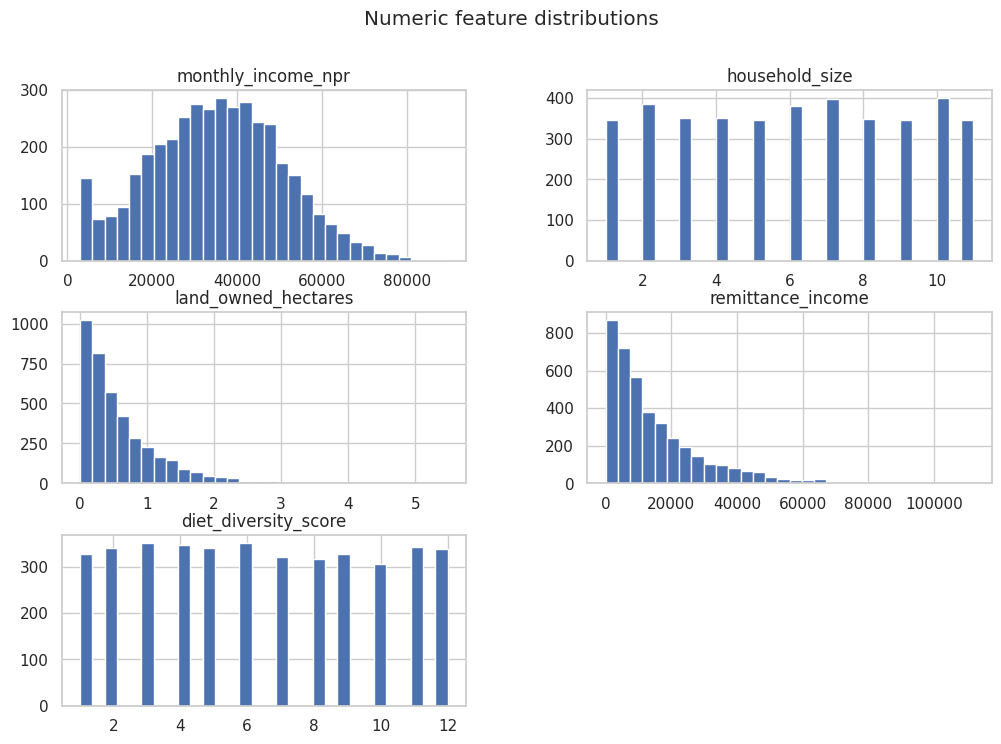

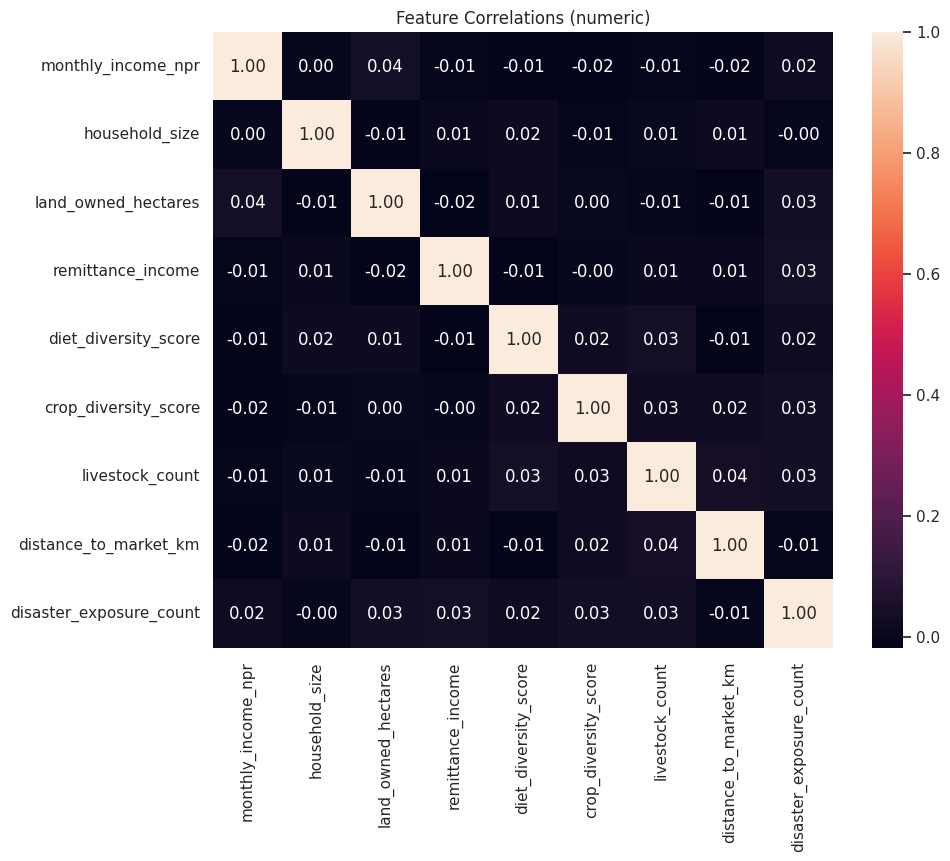

In [9]:
# ---------- 2. Exploratory Data Analysis (brief) ----------

display(df.head())
display(df.describe(include='all'))

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='food_security_status', data=df)
plt.title("Food Security Class Distribution (0=Secure,1=Moderate,2=Severe)")
plt.show()

# Some feature distributions
num_cols = ["monthly_income_npr","household_size","land_owned_hectares","remittance_income","diet_diversity_score"]
df[num_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Numeric feature distributions")
plt.show()

# Correlation heatmap (numerical features)
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols + ["crop_diversity_score","livestock_count","distance_to_market_km","disaster_exposure_count"]].corr(), annot=True, fmt=".2f")
plt.title("Feature Correlations (numeric)")
plt.show()

In [10]:
# ---------- 3. Preprocessing & Feature Engineering ----------
# For modeling, we will:
# - Encode 'district' (one-hot or target encode); to keep it simple and avoid huge expansion, we'll do frequency encoding.
# - Scale numeric features for SVM/Logistic.
# - Keep pipeline modular.

# Frequency encoding for 'district' to keep dimensionality manageable
district_freq = df['district'].value_counts(normalize=True).to_dict()
df['district_freq'] = df['district'].map(district_freq)

# Prepare feature list
feature_cols = [
    "district_freq", "household_size", "monthly_income_npr", "land_owned_hectares",
    "crop_diversity_score", "livestock_count", "distance_to_market_km", "remittance_income",
    "education_years_head", "meals_per_day", "diet_diversity_score", "disaster_exposure_count",
    "water_access"
]

X = df[feature_cols].copy()
y = df['food_security_status'].copy()

# Train-test split (stratify to preserve class ratios)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Standard scaler for models that need scaling (SVM, Logistic)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train shape: (3200, 13) Test shape: (800, 13)


--- Logistic Regression (baseline) ---
Accuracy: 0.6863
F1-score (macro): 0.6946
Classification Report:
               precision    recall  f1-score   support

           0     0.6935    0.7167    0.7049       240
           1     0.6337    0.6450    0.6393       338
           2     0.7644    0.7162    0.7395       222

    accuracy                         0.6863       800
   macro avg     0.6972    0.6926    0.6946       800
weighted avg     0.6879    0.6863    0.6868       800



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


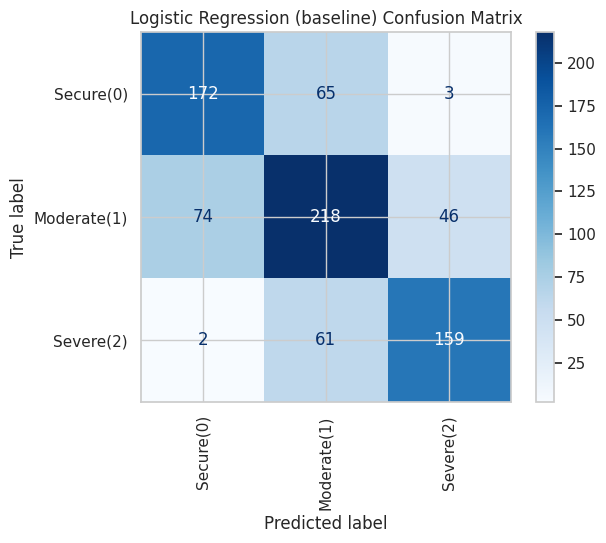

--- Random Forest (baseline) ---
Accuracy: 0.8013
F1-score (macro): 0.8057
Classification Report:
               precision    recall  f1-score   support

           0     0.8664    0.7833    0.8228       240
           1     0.7439    0.8166    0.7786       338
           2     0.8349    0.7973    0.8157       222

    accuracy                         0.8013       800
   macro avg     0.8151    0.7991    0.8057       800
weighted avg     0.8059    0.8013    0.8021       800



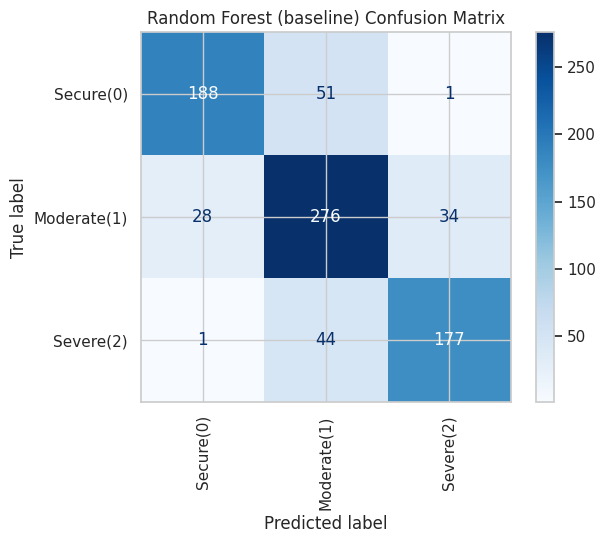

Random Forest feature importances:
 household_size             0.153052
monthly_income_npr         0.152872
land_owned_hectares        0.128691
remittance_income          0.101974
diet_diversity_score       0.081609
distance_to_market_km      0.068310
education_years_head       0.060910
district_freq              0.053580
disaster_exposure_count    0.049161
meals_per_day              0.045222
crop_diversity_score       0.045113
livestock_count            0.037455
water_access               0.022050
dtype: float64


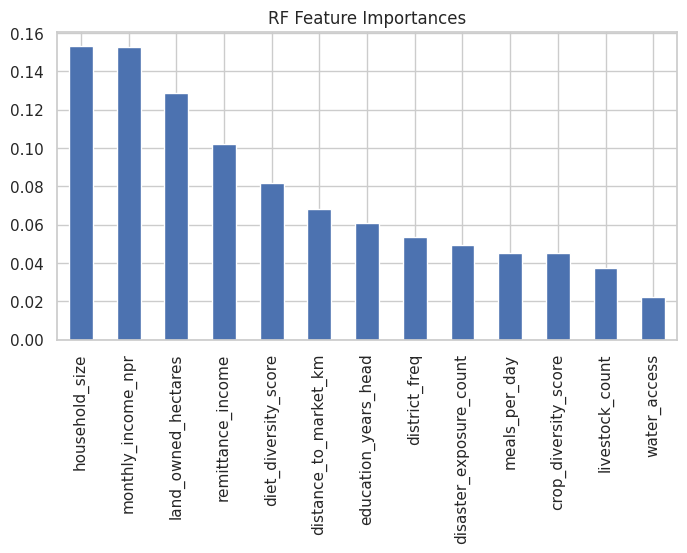

--- SVM (baseline) ---
Accuracy: 0.7425
F1-score (macro): 0.7488
Classification Report:
               precision    recall  f1-score   support

           0     0.7939    0.7542    0.7735       240
           1     0.6822    0.7367    0.7084       338
           2     0.7923    0.7387    0.7646       222

    accuracy                         0.7425       800
   macro avg     0.7561    0.7432    0.7488       800
weighted avg     0.7462    0.7425    0.7435       800



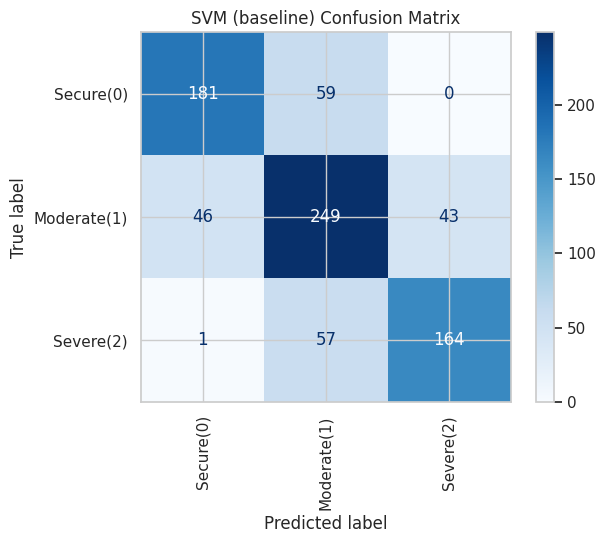

In [11]:
# ---------- 4. Baseline Models: Logistic Regression, Random Forest, SVM ----------

# Helper: function to evaluate and print results
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(model, X_tr, y_tr, X_te, y_te, model_name="Model"):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1_macro = f1_score(y_te, y_pred, average='macro')
    print(f"--- {model_name} ---")
    print("Accuracy:", round(acc,4))
    print("F1-score (macro):", round(f1_macro,4))
    print("Classification Report:\n", classification_report(y_te, y_pred, digits=4))
    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Secure(0)","Moderate(1)","Severe(2)"])
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    return {"accuracy": acc, "f1_macro": f1_macro, "confusion_matrix": cm, "y_pred": y_pred}

# 4.1 Logistic Regression (One-vs-Rest, multinomial with lbfgs)
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_scaled, y_train)
lr_results = evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression (baseline)")

# 4.2 Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)  # RF doesn't require scaling
rf_results = evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest (baseline)")

# Feature importances from RF
fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Random Forest feature importances:\n", fi)
plt.figure(figsize=(8,4))
fi.plot(kind='bar')
plt.title("RF Feature Importances")
plt.show()

# 4.3 Support Vector Machine (SVC)
svc = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
svc.fit(X_train_scaled, y_train)
svc_results = evaluate_model(svc, X_train_scaled, y_train, X_test_scaled, y_test, "SVM (baseline)")




In [ ]:
# ---------- 5. Cross-Validation & Hyperparameter Tuning ----------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 5.1 Random Forest Grid Search
rf_param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 8, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
rf_gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), rf_param_grid,
                     cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
rf_gs.fit(X_train, y_train)
print("RF best params:", rf_gs.best_params_)
best_rf = rf_gs.best_estimator_
rf_gs_results = evaluate_model(best_rf, X_train, y_train, X_test, y_test, "Random Forest (tuned)")




Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
# 5.2 SVM Grid Search (scale features)
svc_param_grid = {
    "C": [0.1, 1, 5],
    "gamma": ['scale', 0.01, 0.1],
    "kernel": ['rbf']
}
svc_gs = GridSearchCV(SVC(probability=True, random_state=RANDOM_STATE), svc_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
svc_gs.fit(X_train_scaled, y_train)
print("SVC best params:", svc_gs.best_params_)
best_svc = svc_gs.best_estimator_
svc_gs_results = evaluate_model(best_svc, X_train_scaled, y_train, X_test_scaled, y_test, "SVM (tuned)")


In [ ]:
# 5.3 Logistic Regression hyperparam tune (optional)
lr_param_grid = {
    "C": [0.01, 0.1, 1, 10]
}
lr_gs = GridSearchCV(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=RANDOM_STATE),
                     lr_param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
lr_gs.fit(X_train_scaled, y_train)
print("LR best params:", lr_gs.best_params_)
best_lr = lr_gs.best_estimator_
lr_gs_results = evaluate_model(best_lr, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression (tuned)")



In [ ]:
# ---------- 6. Ensemble / Model Comparison ----------
models_summary = pd.DataFrame([
    {"model":"Logistic Regression (baseline)","accuracy":lr_results['accuracy'],"f1_macro":lr_results['f1_macro']},
    {"model":"Logistic Regression (tuned)","accuracy":lr_gs_results['accuracy'],"f1_macro":lr_gs_results['f1_macro']},
    {"model":"Random Forest (baseline)","accuracy":rf_results['accuracy'],"f1_macro":rf_results['f1_macro']},
    {"model":"Random Forest (tuned)","accuracy":rf_gs_results['accuracy'],"f1_macro":rf_gs_results['f1_macro']},
    {"model":"SVM (baseline)","accuracy":svc_results['accuracy'],"f1_macro":svc_results['f1_macro']},
    {"model":"SVM (tuned)","accuracy":svc_gs_results['accuracy'],"f1_macro":svc_gs_results['f1_macro']}
])
display(models_summary.sort_values(by='f1_macro', ascending=False))

# ---------- 7. K-means Clustering & PCA Visualization ----------
# Use the whole dataset X (scaled) for clustering to find groups of households (not supervised)
X_all_scaled = scaler.fit_transform(X)

In [ ]:
inertia = []
K_range = range(2,8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_all_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow plot for KMeans')
plt.show()

# Pick k=3 (to compare to classes) or choose elbow-based
k = 3
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=50)
clusters = kmeans.fit_predict(X_all_scaled)

# PCA to 2D for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pcs = pca.fit_transform(X_all_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], hue=clusters, palette='tab10', legend='full', alpha=0.6)
plt.title('KMeans clusters (k=3) visualized with PCA')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

In [ ]:
# Compare clusters with true labels to see overlap
ct = pd.crosstab(clusters, df['food_security_status'])
print("Cluster vs True Label crosstab:\n", ct)

# ---------- 8. Model Explainability (feature importance for RF and logistic coef) ----------
# Random Forest feature importances (from tuned best_rf)
rf_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
rf_imp.plot(kind='bar')
plt.title('Tuned Random Forest Feature Importances')
plt.show()

# Logistic regression coefficients (tuned)
lr_coefs = pd.DataFrame(best_lr.coef_.T, index=X.columns, columns=[f"class_{i}" for i in best_lr.classes_])
display(lr_coefs)

In [ ]:
# ---------- 9. Save models & artifacts ----------
os.makedirs('models', exist_ok=True)
joblib.dump(best_rf, 'models/best_random_forest.joblib')
joblib.dump(best_svc, 'models/best_svc.joblib')
joblib.dump(best_lr, 'models/best_logistic.joblib')
joblib.dump(scaler, 'models/scaler.joblib')
print("Saved models to models/ directory.")
